# **Deep Research with Bing Search**

This notebook demonstrates an agentic research workflow that leverages Azure AI services to conduct comprehensive web-based research on any topic. The workflow includes:

1. **Research Planning** - Breaking down complex queries into structured subtopics and targeted search queries
2. **Information Retrieval** - Using Bing Search API through Azure AI Services to gather relevant web content
3. **Content Analysis** - Summarizing search results and extracting key insights 
4. **Report Generation** - Creating detailed research reports with proper citations
5. **Peer Review** - Evaluating report quality and suggesting improvements until quality standards are met

The notebook orchestrates multiple specialized AI agents working together:
- PlannerAgent - Creates comprehensive research plans with subtopics and queries
- BingSearchAgent - Retrieves relevant search results from the web
- SummaryAgent - Extracts key insights from retrieved content
- ResearchAgent - Compiles findings into structured research reports
- PeerReviewAgent - Provides quality feedback in a continuous improvement loop

Built with Azure OpenAI, Azure AI Projects, and the OpenAI Agents SDK.

## Environment Setup

First, we'll set up our environment by importing necessary libraries and loading environment variables from a .env file. These environment variables contain configuration details such as API keys and endpoints for the Azure OpenAI and Bing Search services.

In [1]:
import dotenv
dotenv.load_dotenv(".env", override=True)

True

### Configure Azure OpenAI to work with OpenAI Agents SDK

In [2]:
import os
from agents import (
    set_default_openai_client,
    set_tracing_disabled,
    OpenAIChatCompletionsModel
)

# setup settings
from openai import AsyncAzureOpenAI
import nest_asyncio
nest_asyncio.apply()

# Use the synchronous client instead of the async one
openai_client = AsyncAzureOpenAI(
    azure_endpoint=os.getenv("AOAI_ENDPOINT"),
    api_key=os.getenv("AOAI_KEY"),
    api_version=os.environ.get("AOAI_API_VERSION", "2024-02-01")
)

# Configure SDK
set_default_openai_client(openai_client)
set_tracing_disabled(True)

reasoningModel = OpenAIChatCompletionsModel(
    model=os.getenv("reasoningModel"), 
    openai_client=openai_client
)

chatModel = OpenAIChatCompletionsModel(
    model=os.getenv("chatModel"),
    openai_client=openai_client
)

## Data Models for Research Workflow

The following Pydantic models define the structured data used throughout our research process:

1. **ResearchTask** - Represents an individual research task with specific search queries
2. **ResearchPlan** - Contains the overall plan with research objectives and tasks
3. **Citation** - Stores source information for proper attribution
4. **ComprehensiveResearchReport** - Defines the structure of the final research output
5. **PeerReviewFeedback** - Contains structured feedback on report quality

In [3]:
from typing import List, Optional
from pydantic import BaseModel, Field

class ResearchTask(BaseModel):
    id: Optional[str] = Field(None, description="Unique identifier for the task")
    subtopic: str = Field(..., description="Subtopic to research")
    search_queries: List[str] = Field(..., description="List of search queries to explore this subtopic")
    completed: bool = Field(..., description="Status of task completion")

class ResearchPlan(BaseModel):
    query: str = Field(..., description="The original user query that prompted this research")
    objective: str = Field(..., description="The overall research objective, clearly defined")
    success_criteria: List[str] = Field(..., description="Criteria to determine when the research is sufficiently complete.")
    related_topics: List[str] = Field(..., description="List of related topics that may be useful for the research.")
    research_tasks: List[ResearchTask] = Field(..., description="List of specific research tasks to complete. Each task focuses on a subtopic.")

class Citation(BaseModel):
    title: str
    url: str

class ComprehensiveResearchReport(BaseModel):
    objective: str = Field(..., description="The original research objective")
    research_report: str = Field(..., description=(
        "Comprehensive research report in markdown. "
        "It should be structured with meaningful headings and subsections, but emphasize **fully-developed paragraphs**. "
        "It should be long and detailed, and it should fully addresses the objectives, "
        "and the various subtopics required to achieve the success criteria. "
        "Use bullet points or lists **only** when they genuinely improve clarity (e.g., summarizing key data). "
        "Tables and other data visualizations are encouraged. "
        "The research report should always be long and detailed.\n\n" 
        "For citations, please use the IEEE (Institute of Electrical and Electronics Engineers). "
        "How it works:\n\n"
        "   1. In the text, use numbered citations in brackets [1].\n"
        "   2. At the end of the report, provide a list of citations in the format "
        "(the list should ONLY contain the sources used in the free text of the research report. "
        "Do NOT list sources which are not cited in the free text of the research report.):\n\n"
        "       [1] Title of the source, URL."
    ))
    citations: List[Citation] = Field(..., description=(
        "List of citations (title and URL), corresponding to references actually used in research_report. "
        "Do not add references that are not cited within the text."
    ))
    identified_gaps: Optional[List[str]] = Field(default=None, description="Identified information gaps.")
    additional_queries: Optional[List[str]] = Field(default=None, description="Suggestions for additional research.")

class PeerReviewFeedback(BaseModel):
    overall_feedback: str = Field(..., description="General feedback on the report.")
    strengths: List[str] = Field(..., description="Aspects of the report that are well done.")
    suggested_improvements: List[str] = Field(..., description="Specific suggestions to improve clarity, completeness, accuracy, or structure.")
    additional_queries: Optional[List[str]] = Field(default=None, description="Additional research queries that could strengthen the report.")
    is_satisfactory: bool = Field(..., description="Indicates if the report meets all quality standards and no further revisions are needed.")
    

## Agent Configuration

The research workflow is powered by two types of agents:

1. **Azure AI Agents** - Created using Azure AI Projects for web search capabilities
2. **OpenAI Agents** - For specialized research tasks

Let's configure each type of agent with their specific instructions and capabilities.

### Azure AI Foundry Connections

First, we'll establish connections to Azure AI Projects, which provides the infrastructure for our Bing Search agent.

In [4]:
from azure.ai.projects import AIProjectClient
from azure.identity import DefaultAzureCredential

project_client = AIProjectClient(
    credential=DefaultAzureCredential(),
    endpoint=os.getenv("PROJECT_ENDPOINT")
)

The following cell will ***create*** an **Azure AI Agent**, so you only need to run this cell **once**.

In [5]:
# from azure.ai.agents.models import BingGroundingTool

# import datetime
# current_date = datetime.datetime.now().strftime("%Y-%m-%d")

# bing_connection = project_client.connections.get(
#     name=os.getenv("BING_CONNECTION_NAME")
# )

# bing_tool = BingGroundingTool(connection_id=bing_connection.id)

# bing_search_agent = project_client.agents.create_agent(
#     name="bingSearchAgent",
#     description="Agent to perform web searches using Bing.",
#     model=os.getenv("chatModel"),
#     temperature=0.5,
#     tools=bing_tool.definitions,
#     instructions=f"""
# You are a helpful research assistant.

# Today's date is {current_date}.

# Use your available tools (like Bing web search) to find information relevant to the user's query.
# When you use information from a search result in your answer, please cite the source clearly using the tool's citation capabilities.
# Provide a comprehensive answer based on the search results.
#     """.strip()
# )

If you already have an Azure AI Agent, run this cell to update it's instructions with today's date.

In [6]:
import datetime
current_date = datetime.datetime.now().strftime("%Y-%m-%d")

bing_search_agent = project_client.agents.get_agent(agent_id=os.getenv("bingSearchAgentID"))
bing_search_agent.instructions = f"""
You are a helpful research assistant.

Today's date is {current_date}.

Use your available tools (like Bing web search) to find information relevant to the user's query.
When you use information from a search result in your answer, please cite the source clearly using the tool's citation capabilities.
Provide a comprehensive answer based on the search results.
""".strip()

print(bing_search_agent.instructions)

You are a helpful research assistant.

Today's date is 2025-06-03.

Use your available tools (like Bing web search) to find information relevant to the user's query.
When you use information from a search result in your answer, please cite the source clearly using the tool's citation capabilities.
Provide a comprehensive answer based on the search results.


**OpenAI Agents**

In [ ]:
from agents import (
    Agent,
    ModelSettings
)

chatModelSettings=ModelSettings(
        max_tokens=32768,
        temperature=0.3,
    )

planner_agent = Agent(
    name="PlannerAgent",
    instructions=f"""
    Today's date is {current_date}.
    
    You are an expert research planner specializing in creating detailed research plans your task is to analyze a user's research query and create a structured research plan.
    with the following components:
    
    1. DOMAIN CLASSIFICATION:
       Classify the query into a fitting domain (e.g., technology, business, etc.).
       The Domain is not included in the output, but it is important for the other components in the research plan.
       The domain should be a single word (e.g., technology, business, etc.).
       
    2. RESEARCH OBJECTIVE:
       Create a clear, comprehensive objective statement for the research
       
    3. SUBTOPICS:
       Generate relevant subtopics that should be explored to thoroughly answer the query (Important. generate no less than 5 subtopics)
       
    4. SEARCH QUERIES:
       For each subtopic, provide search queries that will yield valuable results (Important. It's better to generate more queries than less queries, but at least 3 queries per subtopic)
       
    5. SUCCESS CRITERIA:
       List the criteria that will determine when the research is complete (Important. generate no less than 4 success criteria)
       Take all of the above into account (e.g., the domain, objective, subtopics, and search queries) to create the success criteria.
       
    6. RELATED TOPICS:
       suggest related topics that may be useful for the research (Important. generate no less than 3 related topics)
    
    Ensure each subtopic is thorough and directly relevant to the research query.
    The search queries should be specific enough to return high-quality results.
    """.strip(),
    model=chatModel,
    output_type=ResearchPlan,
    model_settings=chatModelSettings
)

summary_agent = Agent(
    name="SummaryAgent",
    instructions=(
        "You are a comprehensive research summarization specialist. Your task is to **synthesize information from combined search result content** related to a specific subtopic (which will be mentioned in the input prompt). "
        "Create a **single, coherent, detailed, and information-rich summary** that:\n\n"
        "1. Extracts ALL important facts, statistics, findings, and insights **relevant to the specified subtopic** from the combined text.\n"
        "2. Preserves specific numbers, percentages, dates, and technical details whenever present.\n"
        "3. Includes industry-specific terminology and concepts that add depth to the research.\n"
        "4. **Synthesizes** the key arguments and conclusions from the provided sources. If sources present different perspectives or data, try to capture that nuance.\n"
        "5. Provides thorough explanations rather than superficial overviews, integrating information smoothly.\n"
        "6. For technical content, preserves methodologies, technical specifications, and implementation details.\n"
        "7. For comparative content, maintains all sides of the comparison with their specific attributes.\n\n"

        "**Acknowledge that the input combines information potentially from multiple search results.** Your goal is to create a unified summary focused on the overall subtopic, not just list summaries of individual parts.\n\n"

        "Remember that your summary serves as the foundation for generating a comprehensive research report. The quality and depth of the final research report depends directly on how comprehensive and well-synthesized your summary is. Ensure it captures the essence of all provided content relevant to the subtopic.\n\n"

        "FORMAT YOUR SUMMARY AS:\n"
        "## Key Insights\n"
        "- [Most critical takeaway #1]\n"
        "- [Most critical takeaway #2]\n"
        "- [Most critical takeaway #3]\n"
        "- [Optional: Most critical takeaway #4]\n\n"
        "## Extensive Synthesis\n"
        "Write a thorough, multi-paragraph synthesis that:\n"
        "- Integrates all important facts, statistics, findings, and insights relevant to the subtopic.\n"
        "- Preserves specific numbers, percentages, dates, and technical details.\n"
        "- Explains methodologies, technical specifications, and implementation details where relevant.\n"
        "- Highlights agreements, disagreements, and nuances between sources.\n"
        "- Uses industry-specific terminology and concepts.\n"
        "- Provides context, background, and implications for the findings.\n"
        "- Maintains logical flow: start with an overview, then go into specifics, and conclude with implications or open questions."
    ),
    model=chatModel,
    output_type=str,
    model_settings=chatModelSettings
)

research_agent = Agent(
    name="ResearchAgent",
    instructions=(
        "## General Instructions\n"
        "You are a meticulous research analyst specializing in creating **long, comprehensive, authoritative** reports. "
        "Your goal is to produce **in-depth, highly detailed** content that thoroughly analyzes all aspects of the research topic. "
        "Furthermore, you must also demonstrate subject matter expertise with nuanced insights, technical details, and sophisticated analysis.\n\n"
        
        "### Style & Format:\n"
        "- **Default to paragraphs.** Present your findings in cohesive, well-structured paragraphs rather than excessive bullet points.\n"
        "- **Use bullet points sparingly.** Only use them when they add genuine clarity—e.g., summarizing key data.\n"
        "- **Structure** the report with a clear hierarchy, but avoid excessive nesting. Aim for a balanced structure:\n"
        "   - Use main sections and occasional subsections where needed.\n"
        "   - Avoid over-fragmentation by limiting sub-subsections unless absolutely necessary.\n"
        "   - Favor broader thematic groupings to maintain narrative flow and reduce section clutter.\n"
        "   - With that said, if a subtopic would benefit from a sub-subsection, feel free to add it.\n"
        "- **Data visualizations** (e.g., tables, charts, diagrams) in Markdown are encouraged wherever they enhance understanding.\n"
        "- Maintain a logical, flowing structure so each subsection builds upon the prior sections.\n"
        "- **Citations:** Use IEEE style: [1], [2], etc. Provide a 'References' section at the end of your report with only the sources cited in the text.\n\n"
        
        "### Long & Comprehensive Requirement:\n"
        "- The final report must be the equivalent of **10 to 12 pages** of substantive text, approximately **7000-9000 words**.\n"
        "- Each major section should have **extensive exploration** (ideally 800-1000 words per section).\n"
        "- Ensure thorough coverage of the topic with **well-developed paragraphs**, plenty of detail, and rigorous analysis.\n\n"
        
        "### Depth Requirements:\n"
        "- Include **quantitative data**, statistics, and specific examples to support your arguments.\n"
        "- Compare and contrast **multiple perspectives** on complex topics.\n"
        "- Integrate ideas across sections for a cohesive, synthesized analysis rather than isolated observations.\n\n"
        
        "### Workflow\n"
        "- When given the research objective and content, develop a **long-form narrative** with detailed explanations.\n"
        "- If PeerReviewAgent provides feedback, revise thoroughly, addressing all points.\n"
        "- Once feedback is marked satisfactory, present the final report.\n\n"
        
        "### Important Guidelines\n"
        "- Retain high-quality content in any revision.\n"
        "- If feedback highlights missing info, propose specific research queries.\n"
        "- Avoid unnecessary repetition.\n\n"

        "**REMINDER**:"
        "Your output should be a single, cohesive Markdown document that reads like a well-developed academic or professional paper, with minimal use of bullet points. "
        "Prefer broader thematic sections over excessive fragmentation. "
        "Sub-subsections may be used where helpful, but structure should remain balanced and readable. "
        "Lastly, do not forget to include the references section at the end of the report."
    ),
    model=chatModel,
    model_settings=chatModelSettings,
    output_type=ComprehensiveResearchReport,
)

peer_review_agent = Agent(
    name="PeerReviewAgent",
    instructions=(
        "You are a critical yet constructive peer reviewer evaluating research reports. "
        "Your goal is to provide detailed, actionable feedback using a structured evaluation framework.\n\n"
        
        "## Evaluation Framework:\n"
        "1. COMPLETENESS (0-10): Does the report thoroughly cover all aspects of the research topic?\n"
        "   - Are all required subtopics adequately addressed?\n"
        "   - Is there sufficient depth in each section (500+ words per major section)?\n"
        "   - Are there any obvious gaps or missing perspectives?\n\n"
        
        "2. CLARITY & STRUCTURE (0-10): Is the report well-organized and clearly written?\n"
        "   - Does it have a logical flow with clear sections and subsections?\n"
        "   - Are complex concepts explained in accessible language?\n"
        "   - Does it use formatting effectively (headings, lists, tables)?\n\n"
        
        "3. EVIDENCE & SUPPORT (0-10): Is information well-supported?\n"
        "   - Are claims backed by data, statistics, or authoritative sources?\n"
        "   - Are citations used appropriately and consistently?\n"
        "   - Does it include multiple perspectives when appropriate?\n\n"
        
        "4. ANALYSIS & INSIGHT (0-10): Does the report provide valuable analysis?\n"
        "   - Does it go beyond summarizing to provide meaningful insights?\n"
        "   - Does it connect ideas across different sections?\n"
        "   - Does it identify implications and future directions?\n\n"
        
        "## Response Guidelines:\n"
        "- For each criterion, provide a score (0-10) and specific feedback citing examples from the report\n"
        "- In your overall assessment, calculate a total score (0-40)\n"
        "- Reports scoring 32+ (80%) can be marked as satisfactory\n"
        "- For reports below 32, provide clear, prioritized improvement suggestions\n"
        "- Be constructive and specific - point to exact sections that need improvement\n"
        
        "\n\n## Important Rules:"
        "\n- If the report meets all quality standards (score ≥32), simply confirm this by changing the is_satisfactory field to true and hand it back to ResearchAgent."
        "\n- Always perform a handoff to ResearchAgent for final report generation."
    ),
    model=chatModel,
    model_settings=chatModelSettings,
    output_type=PeerReviewFeedback,
)


**hand-offs**

In [8]:
research_agent.handoffs = [peer_review_agent]
peer_review_agent.handoffs = [research_agent]

## Research Workflow

Our system uses specialized AI agents to transform a user query into a comprehensive research report through these steps:

### Process Flow

1. **User Query** → User submits research topic or question
2. **Planning** → PlannerAgent develops structured research plan with objectives and subtopics
3. **Information Retrieval** → BingSearchAgent executes targeted web searches for each area
4. **Analysis** → SummaryAgent processes results, extracting key insights while preserving technical details
5. **Synthesis** → ResearchAgent creates well-structured report with proper citations
6. **Quality Control** → PeerReviewAgent evaluates report for completeness, clarity, and evidence
7. **Revision** → If needed, research report undergoes improvement cycles based on feedback
8. **Delivery** → Final comprehensive, high-quality report delivered to user

This collaborative approach combines the strengths of different specialized agents to produce thorough, evidence-based research that meets predefined quality standards.

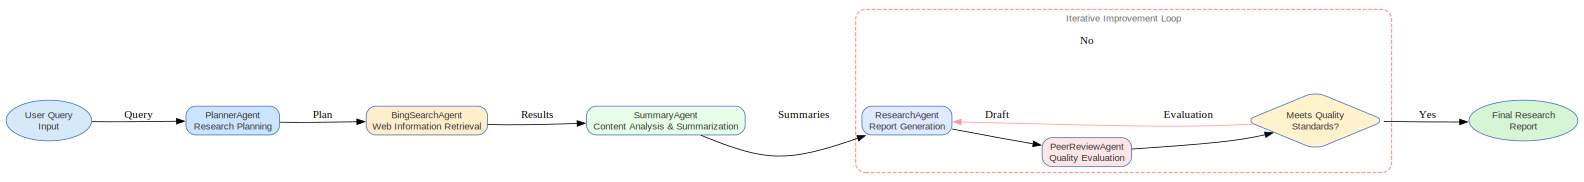

In [9]:
from common.helper import create_research_workflow_diagram

# This will generate research_workflow_diagram.png and return the Digraph object
workflow_diagram = create_research_workflow_diagram()
workflow_diagram

Let's start with a sample research query.

In [10]:
# user_query="What big industries will AI have the most affected on?"
user_query="What are the differences between classical machine learning, deep learning and generative AI?"

### Step 1: Research Planning

The PlannerAgent analyzes the research query and creates a structured plan with:

- Research objective - A clear statement of what the research aims to accomplish
- Subtopics - Key areas to explore for comprehensive coverage
- Search queries - Specific queries for each subtopic to gather relevant information
- Success criteria - Metrics to determine research completeness
- Related topics - Additional areas that may provide valuable context

In [11]:
from agents import Runner

plan = await Runner().run(
    starting_agent=planner_agent,
    input=user_query
)

In [12]:
plan.final_output.research_tasks[0].search_queries

['What is classical machine learning?',
 'Definition of deep learning in AI',
 'What is generative AI?',
 'Foundational principles of classical ML, deep learning, and generative AI',
 'Overview of AI paradigms: classical ML, deep learning, generative AI']

### Step 2: Information Retrieval

The BingSearchAgent executes web searches for each query in our research plan. For each subtopic:

1. We send multiple search queries to gather diverse perspectives
2. The agent returns structured search results with titles, full_text, and URLs
3. Results are organized by subtopic for further processing

This step leverages Azure AI Projects with Bing Search integration to ensure up-to-date information from across the web.

In [13]:
from tqdm import tqdm
from common.utils_search import extract_agent_response_and_urls

search_results = []

for subtopic in tqdm(plan.final_output.research_tasks, desc="Subtopics"):
    subtopic_results = {"subtopic": subtopic.subtopic, "queries": []}

    for query in tqdm(subtopic.search_queries, desc=f"Queries ({subtopic.subtopic})", leave=False):
        formatted_query = f"""
        Research the following query: {query}
        This is related to subtopic: {subtopic.subtopic}
        Please provide the information and cite your sources using the available tools.
        """
        try:
            thread = project_client.agents.threads.create()
            message = project_client.agents.messages.create(
                thread_id=thread.id,
                role="user",
                content=formatted_query,
            )

            # Process the run
            run = project_client.agents.runs.create_and_process(
                thread_id=thread.id,
                agent_id=bing_search_agent.id
            )

            agent_response_text, extracted_urls = extract_agent_response_and_urls(project_client, thread.id, query)

            # Add to our results collection
            subtopic_results["queries"].append({
                "query": query,
                "agent_response": agent_response_text,
                "results": extracted_urls
            })

            # Delete the thread after processing
            project_client.agents.threads.delete(thread_id=thread.id)

        except Exception as e:
            print(f"An error occurred processing query '{query}': {e}")
            # Optionally add error information to results
            subtopic_results["queries"].append({
                "query": query,
                "results": [],
                "error": str(e)
            })

    search_results.append(subtopic_results)

Subtopics: 100%|██████████| 5/5 [04:25<00:00, 53.04s/it]


In [14]:
print(f"Planned total search queries: {sum(1 for task in plan.final_output.research_tasks for search_query in task.search_queries)}\n")
print(f"Actually total search queries: {sum(1 for task in search_results for result in task['queries'])}\n")

Planned total search queries: 25

Actually total search queries: 25



### Step 3: Content Analysis and Summarization

For each search result retrieved, the SummaryAgent:

1. Extracts key facts, statistics, and insights from the raw search content
2. Preserves important technical details, dates, and domain-specific terminology
3. Formats the summary with key insights and detailed paragraph explanations
4. Tracks citations for proper attribution in the final report

This step transforms raw search data into structured, information-rich summaries that will form the basis of our research report.

In [15]:
from common.utils_summary import collect_responses_and_citations

mapped_chunks = []

for subtopic_result in tqdm(search_results, desc="Summarizing subtopics"):
    all_agent_responses_for_subtopic, unique_citations_for_subtopic = collect_responses_and_citations(subtopic_result)

    # --- Summarize the combined agent responses ONCE per subtopic ---
    content_to_summarize = "\n\n---\n\n".join(all_agent_responses_for_subtopic)

    subtopic_summary = "No content found to summarize for this subtopic." # Default value
    if content_to_summarize:
        summary_prompt = f"Summarize the following information related to the subtopic '{subtopic_result.get('subtopic', 'Unknown Subtopic')}':\n\n{content_to_summarize}"
        try:
            summary_response = await Runner().run(
                starting_agent=summary_agent,
                input=summary_prompt
            )
            subtopic_summary = summary_response.final_output # Adjust based on actual response structure
        except Exception as e:
            print(f"Error summarizing subtopic '{subtopic_result.get('subtopic', 'Unknown Subtopic')}': {e}")
            subtopic_summary = f"Error during summarization for subtopic '{subtopic_result.get('subtopic', 'Unknown Subtopic')}'. Details: {e}"
            # Depending on requirements, you might want to raise the exception, log it, or handle it differently

    # --- Convert set of tuples back to list of dictionaries (or Citation objects) ---
    citations_list = [
        {"title": title, "url": url}
        for title, url in unique_citations_for_subtopic
    ]

    # --- Append the consolidated result ---
    mapped_chunks.append({
        "subtopic": subtopic_result.get("subtopic", "Unknown Subtopic"), # Use .get for safety
        "summary": subtopic_summary,
        "citations": citations_list
    })

Summarizing subtopics: 100%|██████████| 5/5 [01:17<00:00, 15.50s/it]


### Step 4: Report Generation and Peer Review

In this final stage:

1. The ResearchAgent synthesizes all summarized content into a comprehensive report
2. The PeerReviewAgent evaluates the report based on completeness, clarity, evidence, and insight
3. If needed, the report is revised based on feedback
4. This cycle continues until quality standards are met

The final report is structured as a cohesive academic-style document with proper citations and a references section.

In [16]:
import json
from common.utils_research import preprocess_research_data

research_input = preprocess_research_data(plan, mapped_chunks)
research_input_prompt = json.dumps(research_input, indent=2)

final_answer = await Runner().run(
    starting_agent=research_agent,
    input=(
        "Create an exceptionally comprehensive, **paragraph-focused** and detailed research report "
        "using the following content. **Minimize bullet points** and ensure the final text resembles "
        "a cohesive, academic-style paper:\n\n"
        f"{research_input_prompt}\n\n"
        "As a final reminder, don't forget to include the citation list at the end of the report."
    ),
    max_turns=21 # 5 turns are needed for a full collaboration between ResearchAgent and PeerReviewAgent
)

### Extracting the Final Research Report

After the ResearchAgent and PeerReviewAgent complete their collaborative process, we extract the final research report from the agent outputs. The report includes:

1. A clearly defined research objective
2. Multiple sections covering all identified subtopics
3. In-depth analysis with facts, statistics, and insights
4. Proper citations using IEEE format
5. A comprehensive references section

In [17]:
from agents import HandoffCallItem
import json

def extract_research_report(final_answer):
    # If final output is from ResearchAgent, get the report directly
    if hasattr(final_answer.final_output, "research_report"):
        return final_answer.final_output.research_report
    
    # If final output is from PeerReviewAgent, find the latest research report from ResearchAgent
    for item in reversed(final_answer.new_items):  # Start from end to get the latest
        if isinstance(item, HandoffCallItem) and item.agent.name == "ResearchAgent":
            try:
                args = json.loads(item.raw_item.arguments)
                if "research_report" in args:
                    return args["research_report"]
            except (json.JSONDecodeError, AttributeError):
                continue
    
    # If we couldn't find a report
    raise ValueError("No research report found in the conversation history")

research_report = extract_research_report(final_answer)

### Final Report Presentation

The completed research report is displayed below in Markdown format. The report represents a comprehensive analysis of the original query, incorporating insights from multiple web sources and structured in an academic format with proper citations.

In [18]:
from IPython.display import display, Markdown
display(Markdown(research_report))

# Comparative Analysis of Classical Machine Learning, Deep Learning, and Generative AI: Principles, Methodologies, Applications, and Interrelationships

## Introduction

The field of artificial intelligence (AI) has undergone a remarkable transformation over the past several decades, evolving from rule-based systems and statistical models to sophisticated neural architectures capable of generating novel content. Central to this evolution are three core paradigms: classical machine learning, deep learning, and generative AI. Each approach is characterized by distinct foundational principles, technical methodologies, and application domains, yet they are deeply interconnected, often building upon and extending the capabilities of their predecessors. As AI technologies become increasingly pervasive across industries, a nuanced understanding of these paradigms—their definitions, architectures, strengths, limitations, and relationships—is essential for practitioners, researchers, and decision-makers seeking to harness their potential.

This report provides an exceptionally comprehensive, integrated analysis of classical machine learning, deep learning, and generative AI. It systematically explores their definitions and foundations, technical architectures, real-world applications, comparative advantages and limitations, and the intricate relationships that bind them. Drawing on authoritative sources, the report aims to clarify the unique contributions and interdependencies of each approach, offering a robust framework for understanding the current landscape and future trajectory of AI.

## 1. Definitions and Foundations of Each Approach

The taxonomy of AI is structured around several core paradigms, each defined by unique methodologies, theoretical underpinnings, and operational mechanisms. Understanding the foundational principles of classical machine learning, deep learning, and generative AI is essential for appreciating their respective roles in contemporary AI applications.

### 1.1 Classical Machine Learning

Classical machine learning (ML) encompasses a suite of algorithms and statistical models developed prior to the deep learning revolution. These methods—including linear regression, logistic regression, decision trees, support vector machines (SVM), k-nearest neighbors (KNN), and clustering algorithms like k-means—are rooted in statistical theory and mathematical rigor. The hallmark of classical ML is its reliance on explicit feature engineering: practitioners manually select, transform, and craft input features based on domain knowledge to optimize model performance. This approach is particularly effective with structured, tabular data and is characterized by its interpretability, transparency, and statistical soundness. Classical ML algorithms are typically less computationally intensive than deep learning models, making them suitable for scenarios with limited data or where model explainability is paramount. The learning paradigms within classical ML include supervised learning (using labeled data), unsupervised learning (discovering patterns in unlabeled data), and reinforcement learning (learning from feedback or rewards). The overarching goal is generalization—ensuring models perform robustly on unseen data, not just the training set [1][4][5][10].

### 1.2 Deep Learning

Deep learning represents a subset of machine learning that leverages multilayered artificial neural networks—often referred to as deep neural networks—to automatically extract and learn hierarchical representations from raw data. Unlike classical ML, deep learning minimizes the need for manual feature engineering by enabling networks to discover relevant features autonomously through multiple layers of abstraction. Core architectures include convolutional neural networks (CNNs) for image data and recurrent neural networks (RNNs) for sequential data, among others. Training deep networks relies on algorithms such as backpropagation and gradient descent to iteratively minimize prediction errors. Deep learning models are highly scalable, often requiring vast datasets and significant computational resources (e.g., GPUs or TPUs) to achieve state-of-the-art performance. This approach excels in complex domains such as image and speech recognition, natural language processing (NLP), and autonomous systems, frequently surpassing human-level accuracy in specialized tasks. However, deep learning models are often considered "black boxes" due to their complexity and lack of interpretability compared to classical ML [2][6][8][11][12][13][15].

### 1.3 Generative AI

Generative AI (GenAI) is a rapidly advancing subfield of AI focused on creating new, original content—including text, images, audio, video, and even software code—that mimics the properties of its training data. Generative AI distinguishes itself from traditional discriminative models by learning the underlying probability distributions of data, enabling the synthesis of novel and realistic artifacts. Foundational models in this space include Generative Adversarial Networks (GANs), which employ an adversarial training process between a generator and a discriminator; Variational Autoencoders (VAEs), which use probabilistic encoding and decoding; and Large Language Models (LLMs) like GPT, which generate human-like text. Generative AI systems are capable of producing content on demand in response to user prompts, powering applications such as conversational agents (e.g., ChatGPT), image generation (e.g., DALL-E), and data augmentation for machine learning pipelines. The creative and synthetic capabilities of generative AI are transforming industries by enabling new forms of content creation, simulation, and automation [7][9][14][16].

### 1.4 Comparative Foundations

A comparative analysis reveals that while classical machine learning emphasizes interpretability, statistical rigor, and manual feature design, deep learning prioritizes automatic hierarchical feature extraction and excels with unstructured, high-dimensional data. Generative AI builds upon both, utilizing advanced deep learning architectures to model and sample from complex data distributions for content generation. Each paradigm is underpinned by distinct technical methodologies—ranging from explicit algorithmic learning and feature engineering in classical ML, to neural network-based representation learning and backpropagation in deep learning, and adversarial or probabilistic generative modeling in GenAI. Understanding these foundational distinctions is essential for selecting the appropriate AI methodology for a given problem and for advancing research and innovation in the field [1][2][7][9].

## 2. Model Architectures and Methodologies

The progression from classical machine learning to deep learning and generative AI is marked by increasingly sophisticated model architectures and training methodologies. Each paradigm is defined by characteristic model families, internal structures, and methodological approaches that determine their suitability for different data types and tasks.

### 2.1 Classical Machine Learning Architectures

Classical ML algorithms are foundational, interpretable, and effective for structured data, relying on well-understood mathematical frameworks and often requiring manual feature engineering. Key models include:

- **Linear Regression**: A supervised regression model that fits a linear equation to the relationship between input features and a continuous output, minimizing the sum of squared errors. Its simplicity and interpretability make it a staple for predictive analytics.
- **Logistic Regression**: Extends linear regression to classification by applying a logistic (sigmoid) function, outputting probabilities for binary outcomes. It is widely used for binary and, with extensions, multiclass classification.
- **Decision Trees**: These models partition data recursively based on feature values, forming a tree structure where nodes represent features, branches represent decision rules, and leaves represent outcomes. Trees are interpretable and can handle both regression and classification.
- **Support Vector Machines (SVMs)**: SVMs identify the optimal hyperplane that maximizes the margin between classes in high-dimensional space. The use of kernel tricks allows SVMs to handle non-linear boundaries efficiently.
- **k-Nearest Neighbors (k-NN)**: An instance-based, non-parametric method that classifies or regresses based on the majority label or average value among the k closest data points, using distance metrics like Euclidean distance.
- **Naive Bayes**: A probabilistic classifier based on Bayes’ theorem, assuming independence among features. It is fast, simple, and effective for text classification and other high-dimensional problems.
- **Principal Component Analysis (PCA)**: An unsupervised dimensionality reduction technique that projects data onto orthogonal axes (principal components) capturing the greatest variance.
- **Clustering Algorithms (e.g., k-Means)**: Unsupervised methods that partition data into clusters by minimizing within-cluster variance, iteratively updating centroids and assignments [1][2][3][4].

These classical models are preferred for their interpretability, efficiency, and effectiveness on small to medium-sized datasets. However, they often require significant manual feature engineering and may struggle with unstructured data such as images or text.

### 2.2 Deep Learning Architectures

Deep learning leverages neural networks with multiple layers to automatically learn hierarchical representations from raw data. Key architectures include:

- **Convolutional Neural Networks (CNNs)**: Designed for spatial data, CNNs use convolutional layers to extract local features, pooling layers for dimensionality reduction, and fully connected layers for final prediction. They dominate image classification, object detection, and medical imaging due to their ability to capture spatial hierarchies.
- **Recurrent Neural Networks (RNNs)**: Suited for sequential data, RNNs maintain hidden states across time steps, enabling modeling of temporal dependencies. Variants like LSTM (Long Short-Term Memory) and GRU (Gated Recurrent Unit) address the vanishing gradient problem, allowing learning of long-range dependencies in tasks like language modeling and speech recognition.
- **Transformers**: Transformers have revolutionized NLP and are increasingly used in vision and multi-modal tasks. Their self-attention mechanism allows modeling of relationships between all elements in a sequence, enabling parallelization and scalability. Key components include multi-head attention, positional encoding, and feed-forward layers. Transformers underpin large language models (LLMs) such as GPT and BERT [5][6][7][8].

Deep learning models excel at learning from unstructured data and have driven breakthroughs in computer vision, NLP, and audio processing. However, they require large datasets and significant computational resources, and their interpretability can be limited compared to classical models.

### 2.3 Generative AI Architectures

Generative AI models are designed to synthesize new data samples that resemble the training data, with applications in image, text, audio, and video generation. The main generative architectures include:

- **Generative Adversarial Networks (GANs)**: Comprise a generator and a discriminator in a zero-sum game. The generator creates synthetic data, while the discriminator distinguishes real from fake. Training is adversarial, with the generator improving to fool the discriminator. GANs are renowned for producing high-fidelity images but can be unstable to train and prone to mode collapse (limited output diversity).
- **Variational Autoencoders (VAEs)**: Feature an encoder-decoder architecture, where the encoder maps inputs to a latent distribution and the decoder reconstructs data from this space. VAEs are trained using variational inference, maximizing a lower bound on data likelihood. They are stable and provide a principled approach to latent space modeling but may produce blurrier outputs than GANs.
- **Diffusion Models**: These models iteratively transform random noise into data samples by learning to reverse a gradual noising process. They have recently set new benchmarks for image quality and diversity, often outperforming GANs in sample fidelity and robustness, though at the cost of higher computational demands and slower sample generation.
- **Large Language Models (LLMs)**: Built on transformer architectures, LLMs like GPT and BERT can generate coherent, contextually relevant text and perform a wide array of language tasks. They exemplify the power of generative modeling in NLP [9][10][11][12].

Generative models differ from traditional ML models in their objective: rather than mapping inputs to labels or values, they learn the underlying data distribution to generate new, realistic samples. This requires more complex architectures and large-scale training data.

### 2.4 Comparative Methodological Distinctions

Traditional ML models are best for structured data, require manual feature engineering, and are valued for interpretability and efficiency. Deep learning models automate feature extraction, handle unstructured data, and are scalable but demand more data and computational power. Generative AI models extend deep learning to content creation, using architectures tailored for synthesis, creativity, and modeling complex data distributions. The selection of model architecture and methodology is a function of data type, task requirements, and practical constraints. As architectures evolve, hybrid approaches and model interpretability remain active areas of research, with ongoing efforts to balance performance, transparency, and computational efficiency [1][2][10][12].

#### Table 1: Comparative Overview of Model Architectures

| Approach                | Core Models/Architectures        | Data Type         | Feature Engineering | Scalability | Interpretability | Typical Use Cases            |
|-------------------------|----------------------------------|-------------------|--------------------|-------------|------------------|------------------------------|
| Classical ML            | Linear/Logistic Regression, SVM, Decision Trees, k-NN, Naive Bayes, PCA, k-Means | Structured        | Manual             | Moderate     | High             | Tabular analytics, risk scoring |
| Deep Learning           | CNNs, RNNs (LSTM, GRU), Transformers | Unstructured      | Automatic           | High        | Low-Moderate     | Image, speech, NLP           |
| Generative AI           | GANs, VAEs, Diffusion, LLMs      | Unstructured      | Automatic           | High        | Low              | Content generation, data synthesis |

## 3. Applications and Use Cases

The practical impact of AI is best illustrated through its diverse applications across industries. Each paradigm—classical machine learning, deep learning, and generative AI—finds its niche in specific domains, shaped by their technical strengths and limitations.

### 3.1 Classical Machine Learning Applications

Classical ML remains foundational for tasks involving structured or tabular data, where interpretability, efficiency, and lower data requirements are paramount. In healthcare, algorithms such as logistic regression, support vector machines (SVM), and decision trees are routinely deployed for disease diagnosis, patient risk prediction, and medical image analysis—enabling clinicians to predict conditions like diabetes or heart disease from patient records. In finance, classical ML powers credit scoring, fraud detection, and algorithmic trading, with linear and logistic regression and tree-based methods assessing loan risk and identifying anomalous transactions. Marketing and customer analytics leverage clustering (e.g., k-means) and classification (e.g., Naïve Bayes) for customer segmentation, churn prediction, and targeted campaigns, helping businesses anticipate and influence customer behavior. Manufacturing benefits from predictive maintenance and quality control, where SVMs and decision trees analyze sensor data to forecast equipment failures or detect product defects. Even in fields like bioinformatics, classical ML supports gene expression analysis and protein classification. While deep learning has made inroads into image recognition, classical methods such as k-nearest neighbors (k-NN) and SVMs remain relevant for simpler image classification tasks, especially when data is limited [1][2][3][4].

### 3.2 Deep Learning Applications

Deep learning has revolutionized applications involving unstructured data—images, audio, video, and natural language—by leveraging neural network architectures that learn hierarchical representations directly from raw data. In healthcare, convolutional neural networks (CNNs) have set new benchmarks in medical image analysis, detecting tumors and other pathologies in MRI and X-ray scans with accuracy surpassing traditional ML. Deep learning also underpins drug discovery, modeling molecular interactions to identify promising compounds. Autonomous vehicles rely on deep learning for real-time object detection, lane-keeping, and pedestrian recognition, enabling safe navigation in complex environments. In natural language processing (NLP), models like GPT and BERT drive language translation, chatbots, sentiment analysis, and text summarization, handling the nuances of human language at scale. Financial institutions use deep learning for advanced fraud detection and algorithmic trading, analyzing vast transaction datasets for subtle patterns. Retail and e-commerce platforms employ deep learning for personalized recommendations, inventory management, and customer experience optimization. In manufacturing, deep learning automates quality control through visual inspection and powers predictive maintenance and robotics. Agriculture leverages deep learning for crop disease detection, yield prediction, and precision farming using drone imagery and sensor data. However, these advances come with requirements for large labeled datasets and significant computational resources [5][6][7][8].

### 3.3 Generative AI Applications

Generative AI represents the cutting edge of AI applications, enabling the creation of new content—text, images, code, and more—by learning data distributions and generating novel outputs. In healthcare, generative models accelerate drug discovery by proposing new chemical compounds and generate synthetic medical images to augment training datasets, improving diagnostic model robustness, especially for rare conditions. Personalized patient communication is enhanced through AI-powered chatbots and virtual assistants. In advertising and marketing, generative AI automates content creation (ad copy, blog posts, social media), personalizes marketing messages, and generates campaign visuals. Manufacturing benefits from AI-driven product design, scenario-based supply chain optimization, and predictive maintenance simulations. Software development is transformed by tools like GitHub Copilot, which generate code snippets, automate testing, and maintain documentation. Financial services use generative models to simulate fraudulent transactions, optimize trading strategies, and automate compliance reporting. In entertainment and media, generative AI creates game characters, stories, music, and visual effects, and automates content localization. Automotive applications include vehicle design optimization, synthetic data generation for autonomous driving, and customer service chatbots. These capabilities are built on deep learning architectures such as transformers (e.g., GPT, DALL-E) and generative adversarial networks (GANs), and require substantial data and computational resources [9][10][11][12].

### 3.4 Comparative Analysis of Use Cases

Comparative analyses reveal distinct strengths and trade-offs. Classical ML is optimal for structured data and interpretable, quick-to-deploy solutions, but struggles with unstructured data. Deep learning excels at extracting complex patterns from unstructured data but demands large datasets and computational power. Generative AI extends deep learning by enabling the creation of new data and automating creative tasks, but introduces complexity and interpretability challenges. For example, in healthcare, classical ML is used for disease risk prediction from tabular records, deep learning for image-based diagnosis, and generative AI for synthesizing rare medical images and automating report generation. The synergy between these approaches is increasingly important—generative AI can augment deep learning models with synthetic data, while classical ML remains indispensable for structured analytics and rapid prototyping [1][2][3][4].

#### Table 2: Impact Assessment Matrix Across Industries

| Industry        | Classical ML Applications        | Deep Learning Applications         | Generative AI Applications         |
|-----------------|----------------------------------|------------------------------------|------------------------------------|
| Healthcare      | Risk prediction, diagnosis       | Medical imaging, drug discovery    | Synthetic images, drug design      |
| Finance         | Credit scoring, fraud detection  | Fraud detection, trading           | Simulated fraud, report automation |
| Marketing       | Customer segmentation, churn     | Recommendation systems             | Content creation, personalization  |
| Manufacturing   | Predictive maintenance, QC       | Visual inspection, robotics        | Product design, simulation         |
| Software Dev    | Bug prediction                   | Code completion                    | Code generation, documentation     |
| Entertainment   | Simple analytics                 | Audio/video analysis               | Story/music generation, VFX        |

## 4. Advantages and Limitations

Each AI paradigm offers distinct advantages and faces unique limitations, influencing their suitability for various applications and deployment scenarios. Understanding these trade-offs is critical for effective model selection and deployment.

### 4.1 Classical Machine Learning

Classical machine learning methods—such as decision trees, support vector machines, and logistic regression—are foundational to AI and remain highly valued, particularly for structured or tabular data. Their primary advantages include high interpretability, with models like linear regression and decision trees offering transparent, easily understood decision processes. This interpretability is crucial in regulated domains such as healthcare and finance, where model transparency underpins trust and compliance. Classical ML models are also computationally efficient, requiring less memory and processing power, and can be effectively trained on smaller datasets. Rapid training times facilitate fast prototyping and experimentation, and the field benefits from a robust theoretical foundation and well-established best practices [1][2][3][4].

However, classical ML faces notable limitations. These models often lack the expressiveness needed to capture complex, nonlinear relationships, particularly in high-dimensional or unstructured data such as images and audio. They typically require extensive manual feature engineering—a process that is both time-consuming and reliant on domain expertise. Scalability can be an issue; while ensemble methods like random forests and gradient boosting machines handle larger datasets better, algorithms like k-nearest neighbors struggle with scale due to their reliance on storing and searching the entire dataset at prediction time. Furthermore, classical ML models are sensitive to data quality, often requiring careful preprocessing to mitigate the effects of noise and outliers. For many modern AI tasks, classical ML has reached a performance ceiling, with deep learning models now surpassing them in accuracy and versatility [1][2][3][4].

### 4.2 Deep Learning

Deep learning—characterized by multi-layered neural networks—has revolutionized AI by enabling breakthroughs in image recognition, speech processing, and natural language understanding. Its key strengths include the ability to automatically extract relevant features from raw data, eliminating the need for manual feature engineering. Deep learning models are highly scalable, capable of leveraging vast datasets and computational resources to improve performance continually. This scalability and adaptability make them suitable for big data applications and a wide array of domains, from autonomous vehicles to medical diagnostics. Deep learning's versatility is further demonstrated by its capacity to handle unstructured data and its continuous improvement as more data and computational power become available [5][6][7][8].

The limitations of deep learning are significant. These models are data-hungry, often requiring millions of labeled examples to reach optimal performance—a barrier in domains where labeled data is scarce or expensive to obtain. Training and deploying deep learning models is computationally intensive, necessitating powerful GPUs and substantial memory, which can drive up costs and environmental impact. Deep neural networks are often criticized for their "black box" nature, as their complex architectures obscure the rationale behind predictions, complicating efforts to ensure fairness, accountability, and regulatory compliance. There is also a heightened risk of overfitting, especially with limited or non-diverse datasets, and developing, tuning, and deploying these models demands specialized expertise. Additionally, if training data contains biases, deep learning models can perpetuate or amplify these biases, raising ethical and societal concerns [5][6][7][8].

### 4.3 Generative AI

Generative AI—encompassing models like generative adversarial networks (GANs) and large language models (LLMs)—has enabled transformative applications in content creation, design, and scientific discovery. Generative AI can synthesize new text, images, and audio, augment datasets, and power advanced tools such as chatbots and design assistants. These capabilities are driving innovation in creative and scientific fields, offering new ways to approach problem-solving and data augmentation [9][10][11][12].

Despite these advances, generative AI is constrained by several critical limitations. The quality and fairness of its outputs are directly tied to the data it is trained on; biases or inaccuracies in training data can lead to biased or misleading outputs. Generative AI models do not possess true understanding or reasoning, instead relying on statistical patterns, which can result in the generation of factually incorrect or fabricated information—a phenomenon known as "hallucination." These models are also resource-intensive, requiring substantial computational power for both training and inference, which can be costly and environmentally taxing. The ease with which generative AI can create deepfakes, fake news, or plagiarized content raises profound ethical and legal questions, necessitating robust guidelines and safeguards. Furthermore, generative AI often struggles to generalize to domains significantly different from its training data and lacks the genuine creativity and contextual awareness of human creators [9][10][11][12].

### 4.4 Scalability, Interpretability, and Deployment Challenges

Scalability and interpretability present additional axes for comparison. Linear and logistic regression, as well as decision trees, offer high interpretability but may not scale effectively to complex, high-dimensional data. Ensemble methods like random forests and gradient boosting machines improve scalability but at the cost of transparency, while deep neural networks offer unmatched scalability and accuracy on large, unstructured datasets but are typically opaque. The trade-off between scalability and interpretability is a central consideration in model selection, particularly in applications where trust, explainability, and regulatory compliance are paramount.

Deployment challenges are common across all AI paradigms. Models must be monitored for drift as data distributions evolve, integrated seamlessly into production environments, and continuously updated to maintain performance. Regulatory and ethical compliance is increasingly important, especially as AI systems are deployed in sensitive or high-stakes domains [13][14][15][16].

#### Table 3: Comparative Advantages and Limitations

| Approach        | Advantages                                   | Limitations                                  |
|-----------------|----------------------------------------------|----------------------------------------------|
| Classical ML    | Interpretability, efficiency, small data     | Limited expressiveness, manual features      |
| Deep Learning   | Automatic features, unstructured data, scale | Data/computation intensive, black-box        |
| Generative AI   | Content creation, data augmentation          | Bias, hallucination, resource/ethical issues |

## 5. Relationships and Overlaps Between Approaches

The relationship between classical machine learning, deep learning, and generative AI is best understood as a nested hierarchy within the broader field of artificial intelligence, with each approach building upon the foundations of its predecessor and extending the range of solvable problems and applications.

### 5.1 Hierarchical Structure and Conceptual Overlap

At the highest level, AI encompasses all techniques that enable computers to mimic human intelligence, including rule-based systems, expert systems, and learning algorithms. Classical machine learning refers to a set of algorithms—such as decision trees, support vector machines (SVMs), logistic regression, and k-nearest neighbors—that learn patterns from data to make predictions or classifications. A defining characteristic of classical ML is the reliance on manual feature engineering: domain experts must select and preprocess the most relevant data characteristics for the model to learn from. This approach is particularly effective for structured data (e.g., tabular datasets) and smaller sample sizes, where statistical methods can efficiently identify relationships. However, classical ML struggles with unstructured data types such as images, audio, and natural language, and with modeling highly complex, nonlinear relationships [1][2][3][4].

Deep learning is a specialized subfield of machine learning that uses artificial neural networks with multiple layers—hence the term "deep." These deep neural networks are capable of automatically learning hierarchical representations and complex features directly from raw data, significantly reducing the need for manual feature engineering. Deep learning excels at processing unstructured data, such as images, speech, and text, and has driven major advances in fields like computer vision and natural language processing. However, deep learning models require large volumes of data and substantial computational resources to achieve their superior performance. Despite these differences, both classical ML and deep learning share foundational principles, such as learning from data, optimizing parameters, and improving performance through experience [5][6][7][8].

Generative AI represents a further specialization within deep learning. It encompasses models designed to generate new data instances that resemble the training data, such as realistic images, coherent text, or synthetic audio. Key technologies in this area include Generative Adversarial Networks (GANs), Variational Autoencoders (VAEs), and large language models (LLMs) like GPT. Generative AI models are built upon deep learning architectures and leverage advances like transformers and adversarial training to create highly realistic and creative outputs. While all generative AI models are deep learning models, not all deep learning models are generative; many are discriminative, focusing on classification or detection tasks [9][10][11][12].

### 5.2 Practical Synergies and Hybridization

The overlaps and relationships between these approaches are both conceptual and practical. Deep learning automates the feature extraction process that is manual in classical ML, enabling the modeling of more complex, high-dimensional data. Generative AI, in turn, extends deep learning from analysis and prediction to content creation. There is also a practical synergy: generative AI can create synthetic data to augment training datasets for classical ML or deep learning models, particularly when real data is scarce. Conversely, predictive models from classical ML or deep learning can be used to guide or evaluate generative processes.

This progression—from classical ML to deep learning to generative AI—reflects a technological continuum. Classical ML established core concepts like supervised and unsupervised learning, which remain foundational in DL and GenAI. Deep learning emerged to address classical ML's limitations with unstructured data, and generative AI further extends these capabilities to the creation of new, original content. All three approaches use core machine learning principles such as optimization, loss functions, and data-driven learning, but differ in their technical implementations, data requirements, and end goals [13][14][15][16].

#### Figure 1: Hierarchical Breakdown of AI Paradigms

```
Artificial Intelligence
├── Machine Learning (ML)
│   ├── Classical ML
│   └── Deep Learning (DL)
│       └── Generative AI (GenAI)
```

### 5.3 Integrated Application and Future Directions

In summary, while classical machine learning, deep learning, and generative AI have distinct methodologies and strengths, they are deeply interconnected. Advances in one area often benefit the others, and in modern AI applications, these approaches are frequently combined to leverage their respective advantages. The taxonomy can be visualized as AI ⊇ ML ⊇ DL ⊇ GenAI, with each subset inheriting and extending the capabilities of its parent, and with significant overlap in techniques, principles, and practical use cases. This layered relationship enables AI systems to tackle an ever-broader array of complex, real-world problems, from structured data analysis to the generation of novel content [13][14][15][16].

## Conclusion

The comparative analysis of classical machine learning, deep learning, and generative AI reveals a rich tapestry of methodologies, technical architectures, and application domains. Classical ML remains indispensable for structured data and interpretable models, offering efficiency and transparency in regulated industries. Deep learning has unlocked new possibilities in perception and language, automating feature extraction and excelling with unstructured data at scale. Generative AI is pioneering the frontier of creative and synthetic intelligence, enabling the generation of new content and transforming workflows across industries. Each paradigm carries inherent advantages and limitations, shaped by data requirements, scalability, interpretability, and ethical considerations. Their relationships are best understood as a continuum, with each approach building upon and extending the capabilities of its predecessors. As AI continues to evolve, the integration and hybridization of these paradigms will drive further innovation, expanding the boundaries of what is possible in artificial intelligence.

## References

[1] Artificial Intelligence (AI), Machine Learning (ML) & Deep Learning (DL ... https://ieeexplore.ieee.org/document/10625198
[2] What is deep learning? | How deep learning works - Cloudflare https://www.cloudflare.com/learning/ai/what-is-deep-learning/
[3] 13 foundational AI courses, resources from MIT | Open Learning https://openlearning.mit.edu/news/13-foundational-ai-courses-resources-mit
[4] Learning Paradigms in AI | Accenture https://www.accenture.com/us-en/blogs/data-ai/learning-paradigms-ai
[5] Classical Machine Learning: Seventy Years of Algorithmic Learning Evolution https://arxiv.org/abs/2408.01747
[6] Deep Learning: A Comprehensive Overview on Techniques, Taxonomy ... https://link.springer.com/article/10.1007/s42979-021-00815-1
[7] What is Generative AI? - IBM https://www.ibm.com/think/topics/generative-ai
[8] Foundations of Deep Learning - SpringerLink https://link.springer.com/book/10.1007/978-981-16-8233-9
[9] Generative AI: What Is It, Tools, Models, Applications and ... - Gartner https://www.gartner.com/en/topics/generative-ai
[10] Understanding Machine Learning Principles: Learning, Inference ... - MDPI https://www.mdpi.com/2227-7390/13/3/451
[11] Deep Learning Definition | DeepAI https://deepai.org/machine-learning-glossary-and-terms/deep-learning
[12] Machine Learning and Deep Learning Paradigms: From Techniques to ... - MDPI https://www.mdpi.com/2073-431X/14/3/93
[13] What Is Deep Learning? - IBM https://www.ibm.com/think/topics/deep-learning
[14] Generative artificial intelligence - Wikipedia https://en.wikipedia.org/wiki/Generative_artificial_intelligence
[15] [2106.10165] The Principles of Deep Learning Theory - arXiv.org https://arxiv.org/abs/2106.10165
[16] What is the difference between traditional vs generative AI ... https://www.servicenow.com/ai/what-is-the-difference-between-traditional-vs-generative-ai.html
[17] What is a Generative Model? - DataCamp https://www.datacamp.com/blog/what-is-a-generative-model
[18] Traditional AI vs Generative AI vs Agentic AI - ML Journey https://mljourney.com/traditional-ai-vs-generative-ai-vs-agentic-ai/
[19] Generative AI vs Traditional AI - GeeksforGeeks https://www.geeksforgeeks.org/difference-between-generative-ai-and-traditional-ai/
[20] Generative AI vs. Traditional Machine Learning: What's the ... - LinkedIn https://www.linkedin.com/pulse/generative-ai-vs-traditional-machine-learning-whats-shrivastava
[21] Generative Models Explained: VAEs, GANs, Diffusion, Transformers ... https://bestarion.com/generative-models-explained-vaes-gans-diffusion-transformers-autoregressive-models-nerfs/
[22] Technology Foundations of Generative AI: Architectures ... - PwC https://www.pwc.de/en/digitale-transformation/generative-ai-artificial-intelligence/the-genai-building-blocks/technology-foundations-of-generative-ai-architectures-algorithms-and-innovations.html
[23] Comparing Diffusion, GAN, and VAE Techniques - Generative AI Lab https://generativeailab.org/l/generative-ai/a-tale-of-three-generative-models-comparing-diffusion-gan-and-vae-techniques/569/
[24] Generative Models in AI: A Comprehensive Comparison of GANs and VAEs ... https://www.geeksforgeeks.org/generative-models-in-ai-a-comprehensive-comparison-of-gans-and-vaes/
[25] A Comprehensive Overview and Comparative Analysis on Deep https://arxiv.org/pdf/2305.17473
[26] Modern AI: GenAI vs Machine Learning vs Deep Learning vs LLMs - Cloud4C https://www.cloud4c.com/blogs/genai-vs-machine-learning-vs-deep-learning-vs-llms
[27] A Comprehensive Review of Deep Learning: Architectures, Recent ... - MDPI https://www.mdpi.com/2078-2489/15/12/755
[28] Diffusion Models vs. GANs vs. VAEs: Comparison of Deep Generative ... https://towardsai.net/p/generative-ai/diffusion-models-vs-gans-vs-vaes-comparison-of-deep-generative-models
[29] Application of classical and advanced machine learning models to ... https://www.sciencedirect.com/science/article/pii/S0957417422025179
[30] Classic Machine Learning Methods - SpringerLink https://link.springer.com/protocol/10.1007/978-1-0716-3195-9_2
[31] Introducing AI Max for Search campaigns - The Keyword https://blog.google/products/ads-commerce/google-ai-max-for-search-campaigns/
[32] Semrush Report: AI Overviews’ Impact on Search in 2025 https://www.semrush.com/blog/semrush-ai-overviews-study/
[33] 20 Examples of Generative AI Applications Across Industries https://www.coursera.org/articles/generative-ai-applications
[34] Generative AI Use Cases Across Industries | Gartner https://www.gartner.com/en/articles/generative-ai-use-cases
[35] 21 Generative AI Examples and its Applications Across Industries https://whatsthebigdata.com/generative-ai-examples/
[36] Top 120 Generative AI Applications with Real-Life Examples - AIMultiple https://research.aimultiple.com/generative-ai-applications/
[37] Top Generative AI Industry Applications & Use Cases - Turing https://www.turing.com/resources/generative-ai-applications
[38] Challenges and Emerging Issues for Generative AI and Hyper Intelligence ... https://ieeexplore.ieee.org/document/10795737
[39] AI Mode in Google Search: Updates from Google I/O 2025 - The Keyword https://blog.google/products/search/google-search-ai-mode-update/
[40] On the Challenges and Opportunities in Generative AI - arXiv.org https://arxiv.org/html/2403.00025v1
[41] ML and AI Model Explainability and Interpretability - Analytics Vidhya https://www.analyticsvidhya.com/blog/2025/01/explainability-and-interpretability/
[42] Machine Learning Interpretability: A Survey on Methods and Metrics - MDPI https://www.mdpi.com/2079-9292/8/8/832
[43] Semrush Report: AI Overviews’ Impact on Search in 2025 https://www.semrush.com/blog/semrush-ai-overviews-study/
[44] Challenges with developing and deploying AI models and applications in ... https://link.springer.com/article/10.1007/s44163-024-00151-2
[45] Decoding the AI Search Flow: From User Query to ... - ServiceNow https://www.servicenow.com/community/now-assist-articles/decoding-the-ai-search-flow-from-user-query-to-intelligent/ta-p/3259475
[46] Pros and Cons of Various Machine Learning Models: A Comparison https://machinelearningmodels.org/pros-and-cons-of-various-machine-learning-models-a-comparison/
[47] Overcoming Challenges in Deploying Large Language Models for Generative ... https://ijcttjournal.org/2024/Volume-72%20Issue-2/IJCTT-V72I2P114.pdf
[48] What is generative AI? - IBM Research https://research.ibm.com/blog/what-is-generative-AI
[49] AI vs. Machine Learning vs. Deep Learning vs. Neural Networks - IBM https://www.ibm.com/think/topics/ai-vs-machine-learning-vs-deep-learning-vs-neural-networks
[50] Tracing the evolution of AI in the past decade and forecasting the ... https://www.sciencedirect.com/science/article/pii/S0957417422013732
[51] Deep Learning vs Classical Machine Learning: The Key Differences https://techimpo.com/deep-learning-vs-classical-machine-learning/
[52] Generative Artificial Intelligence: Fundamentals and Evolution - Springer https://link.springer.com/chapter/10.1007/978-981-97-8460-8_1
[53] Gen AI vs Machine Learning vs Deep Learning - DataSpace Academy https://dataspaceacademy.com/blog/genai-vs-machine-learning-vs-deep-learning-a-comparative-study
[54] The Evolution of AI Architecture: From Traditional Machine Learning to ... https://aimresearch.co/generative-ai/the-evolution-of-ai-architecture-from-traditional-machine-learning-to-generative-ai
[55] AI, ML, DL, and Generative AI Face Off: A Comparative Analysis https://synoptek.com/insights/it-blogs/data-insights/ai-ml-dl-and-generative-ai-face-off-a-comparative-analysis/
[56] When to Use GenAI Versus Predictive AI - MIT Sloan Management Review https://sloanreview.mit.edu/article/when-to-use-genai-versus-predictive-ai/
[57] What is artificial intelligence, machine learning, and deep learning ... https://www.sciencedirect.com/science/article/pii/B9780443221323000022
[58] Machine learning and generative AI: What are they good for in 2025? https://mitsloan.mit.edu/ideas-made-to-matter/machine-learning-and-generative-ai-what-are-they-good-for
[59] Deep Learning vs. Machine Learning: A Beginner’s Guide https://www.coursera.org/articles/ai-vs-deep-learning-vs-machine-learning-beginners-guide
[60] Unveiling the evolution of generative AI (GAI): a comprehensive and ... https://jesit.springeropen.com/articles/10.1186/s43067-024-00145-1
[61] Understanding Artificial Intelligence Hierarchy: How AI, ML, Gen AI ... https://devblogit.com/understanding-artificial-intelligence-ai-hierarchy


### Research Workflow Visualization

Below we can see the detailed steps in the research and review process, showing how the ResearchAgent and PeerReviewAgent collaborated to produce the final report. This visualization helps us understand how many iterations were required to meet quality standards.

In [19]:
from common.helper import pretty_print_agent_workflow
pretty_print_agent_workflow(final_answer)

🔍 AGENT WORKFLOW: 'Create an exceptionally comprehensive, **paragraph-focused** and detailed research report using the following content. **Minimize bullet points** and ensure the final text resembles a cohesive, academic-style paper:

{
  "objective": "To comprehensively compare and contrast classical machine learning, deep learning, and generative AI, examining their underlying principles, methodologies, applications, advantages, limitations, and interrelationships.",
  "aggregated_summaries": [
    {
      "subtopic": "Definitions and Foundations of Each Approach",
      "summary": "Acknowledge: The following synthesis integrates information from multiple search results to provide a unified, comprehensive summary of the definitions and foundational principles underlying classical machine learning, deep learning, and generative AI.\n\n---\n\n## Key Insights\n- **Classical machine learning is grounded in statistical theory, relies on explicit feature engineering, and employs well-unde